In [1]:
### Bibliotecas 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import streamlit as st
pd.set_option('display.max_columns',None)
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
# Cargamos los 3 años de datos 

data_2018 = pd.read_csv('./data/ground_water_quality_2018_post.csv')
data_2019 = pd.read_csv('./data/ground_water_quality_2019_post.csv')
data_2020 = pd.read_csv('./data/ground_water_quality_2020_post.csv') # Utilizaremos el 2020 para el test

In [3]:
# Revisamos si la bases de datos estan compuestas por la misma cantidad de columnas 

print(data_2018.shape)
print(data_2019.shape)
print(data_2020.shape)

(374, 26)
(364, 26)
(368, 27)


In [4]:
# 2020 contiene una columna más que el resto de años verificamos que información tenemos 
data_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sno               368 non-null    int64  
 1   district          368 non-null    object 
 2   mandal            368 non-null    object 
 3   village           368 non-null    object 
 4   lat_gis           368 non-null    float64
 5   long_gis          368 non-null    float64
 6   gwl               365 non-null    float64
 7   season            368 non-null    object 
 8   Unnamed: 8        0 non-null      float64
 9   pH                368 non-null    object 
 10  E.C               368 non-null    int64  
 11  TDS               368 non-null    float64
 12  CO3               368 non-null    float64
 13  HCO3              368 non-null    int64  
 14  Cl                368 non-null    int64  
 15  F                 368 non-null    float64
 16  NO3               368 non-null    float64
 1

In [5]:
# Al tratarse de una columna vacía la eliminammos 
data_2020.drop("Unnamed: 8",axis=1, inplace=True)
data_2020.drop("season",axis=1, inplace=True)
data_2020['anyo']=2020

In [6]:
data_2018.drop('season',axis=1,inplace=True)
data_2018['anyo']=2018

In [7]:
data_2019.drop('season',axis=1,inplace=True)
data_2019['anyo']=2019

In [8]:
print(data_2018.shape)
print(data_2019.shape)
print(data_2020.shape)

(374, 26)
(364, 26)
(368, 26)


In [9]:
data_2018.head(1)

,sno,district,mandal,village,lat_gis,long_gis,gwl,pH,E.C,TDS,CO3,HCO3,Cl,F,NO3,SO4,Na,K,Ca,Mg,T.H,SAR,Classification,RSC meq / L,Classification.1,anyo
0,1,ADILABAD,Adilabad,Adilabad,19.6683,78.5247,5.09,8.28,745,476.8,0,220.0,60,0.44,42.276818,46.0,49.0,4.0,48,38.896,279.934211,1.273328,C2S1,-1.198684,P.S.,2018


In [10]:
data_2019.head(2)

,sno,district,mandal,village,lat_gis,long_gis,gwl,pH,EC,TDS,CO_-2,HCO_ -,Cl -,F -,NO3-,SO4-2,Na+,K+,Ca+2,Mg+2,T.H,SAR,Classification,RSC meq / L,Classification.1,anyo
0,1,ADILABAD,Adilabad,Adilabad,19.668300,78.524700,6.45,8.32,2355,1507.2,30.0,320,340,0.64,66.435000,377.0,273.0,113.0,80.0,82.654,539.860197,5.108509,C4S2,-3.797204,P.S.,2019
1,2,ADILABAD,Bazarhatnur,Bazarhatnur,19.458888,78.350833,3.85,8.30,565,361.6,20.0,180,40,2.21,38.049136,52.0,89.0,14.0,48.0,4.862,139.991776,3.196982,C2S1,1.200164,P.S.,2019


In [11]:
data_2020.head(2)

,sno,district,mandal,village,lat_gis,long_gis,gwl,pH,E.C,TDS,CO3,HCO3,Cl,F,NO3,SO4,Na,K,Ca,Mg,T.H,SAR,Classification,RSC meq / L,Classification.1,anyo
0,1,ADILABAD,Adilabad,Adilabad,19.668300,78.524700,7.10,8.01,1477,945.28,0.0,390,220,0.65,6.442182,33.0,171.0,9.0,24.0,72.930,359.876645,3.919146,C3S1,0.602467,P.S.,2020
1,2,ADILABAD,Bazarhatnur,Bazarhatnur,19.458888,78.350833,3.35,7.77,823,526.72,0.0,250,50,0.66,97.438000,13.5,70.0,3.0,16.0,53.482,259.909539,1.887814,C3S1,-0.198191,P.S.,2020


In [12]:
data_2020.at[261, 'pH']= 8.05

In [13]:
# Renombramos las columnas de 2019 siguiendo el esquema de 2018 ya que el mismo coincide con 2020
column_name={'CO_-2 ':'CO3', 'HCO_ - ':'HCO3', 'Cl -':'Cl', 'F -':'F','NO3- ':'NO3 ', 
             'SO4-2':'SO4', 'Na+':'Na', 'K+':'K', 'Ca+2':'Ca', 'Mg+2':'Mg', 'EC':'E.C'}
data_2019.rename(columns=column_name,inplace=True)


In [14]:
# Revisamos si tenemos valores nulos en cada año 

print(data_2018.isnull().sum())
print(data_2019.isnull().sum())
print(data_2020.isnull().sum())

sno                 0
district            0
mandal              0
village             0
lat_gis             0
long_gis            0
gwl                 3
pH                  0
E.C                 0
TDS                 0
CO3                 0
HCO3                0
Cl                  0
F                   0
NO3                 0
SO4                 0
Na                  0
K                   0
Ca                  0
Mg                  0
T.H                 0
SAR                 0
Classification      0
RSC  meq  / L       0
Classification.1    0
anyo                0
dtype: int64
sno                   0
district              0
mandal                0
village               0
lat_gis               0
long_gis              0
gwl                   5
pH                    0
E.C                   0
TDS                   0
CO3                 160
HCO3                  0
Cl                    0
F                     0
NO3                   0
SO4                   0
Na                    0
K      

In [15]:
data_2019.head(1)

,sno,district,mandal,village,lat_gis,long_gis,gwl,pH,E.C,TDS,CO3,HCO3,Cl,F,NO3,SO4,Na,K,Ca,Mg,T.H,SAR,Classification,RSC meq / L,Classification.1,anyo
0,1,ADILABAD,Adilabad,Adilabad,19.6683,78.5247,6.45,8.32,2355,1507.2,30.0,320,340,0.64,66.435,377.0,273.0,113.0,80.0,82.654,539.860197,5.108509,C4S2,-3.797204,P.S.,2019


In [16]:
# Calcular la media de la columna "CO3" por distrito en 2018, 2019 y 2020
mean_co3_2018 = data_2018.groupby('district')['CO3'].mean()
mean_co3_2019 = data_2019.groupby('district')['CO3'].mean()
mean_co3_2020 = data_2020.groupby('district')['CO3'].mean()

# Crear un diccionario para mapear las medias por distrito en 2019
co3_mean_dict_2019 = mean_co3_2019.to_dict()

# Sustituir los valores nulos en 2019 con las medias por distrito de 2019
data_2019['CO3'].fillna(data_2019['district'].map(co3_mean_dict_2019), inplace=True)

# Verificar si todavía hay valores nulos en 2019
print("Valores nulos en 2019 (después de la imputación):", data_2019['CO3'].isnull().sum())


Valores nulos en 2019 (después de la imputación): 81


In [17]:
print(data_2019.isnull().sum())

sno                  0
district             0
mandal               0
village              0
lat_gis              0
long_gis             0
gwl                  5
pH                   0
E.C                  0
TDS                  0
CO3                 81
HCO3                 0
Cl                   0
F                    0
NO3                  0
SO4                  0
Na                   0
K                    0
Ca                   0
Mg                   0
T.H                  0
SAR                  0
Classification       0
RSC  meq  / L        0
Classification.1     0
anyo                 0
dtype: int64


Seguimos teneiendo un total de 81 datos nulos para la columna CO3. Aplicaremos una regresión lineal para imputar estos nulos

In [18]:
data_agua=pd.concat([data_2018,data_2019])


In [19]:
data_agua['anyo'].value_counts()

anyo
2018    374
2019    364
Name: count, dtype: int64

In [20]:
data_agua.isnull().sum()

sno                  0
district             0
mandal               0
village              0
lat_gis              0
long_gis             0
gwl                  8
pH                   0
E.C                  0
TDS                  0
CO3                 81
HCO3                 0
Cl                   0
F                    0
NO3                  0
SO4                  0
Na                   0
K                    0
Ca                   0
Mg                   0
T.H                  0
SAR                  0
Classification       0
RSC  meq  / L        0
Classification.1     0
anyo                 0
dtype: int64

In [21]:
# Calcular la media de la columna "CO3"
mean_co3 = data_agua['CO3'].mean()

# Sustituir los valores nulos en 2019 con la media de la columna "CO3"
data_agua['CO3'].fillna(mean_co3, inplace=True)

# Verificar si todavía hay valores nulos en 2019
print("Valores nulos en 2019 (después de la imputación):", data_agua['CO3'].isnull().sum())


Valores nulos en 2019 (después de la imputación): 0


In [22]:
data_agua.isnull().sum()

sno                 0
district            0
mandal              0
village             0
lat_gis             0
long_gis            0
gwl                 8
pH                  0
E.C                 0
TDS                 0
CO3                 0
HCO3                0
Cl                  0
F                   0
NO3                 0
SO4                 0
Na                  0
K                   0
Ca                  0
Mg                  0
T.H                 0
SAR                 0
Classification      0
RSC  meq  / L       0
Classification.1    0
anyo                0
dtype: int64

In [23]:
# Calcular la media de la columna 'gwl'
mean_gwl = data_agua['gwl'].mean()

# Sustituir los valores nulos en 'gwl' con la media de la columna 'gwl'
data_agua['gwl'].fillna(mean_gwl, inplace=True)

In [24]:
data_agua.isnull().sum()

sno                 0
district            0
mandal              0
village             0
lat_gis             0
long_gis            0
gwl                 0
pH                  0
E.C                 0
TDS                 0
CO3                 0
HCO3                0
Cl                  0
F                   0
NO3                 0
SO4                 0
Na                  0
K                   0
Ca                  0
Mg                  0
T.H                 0
SAR                 0
Classification      0
RSC  meq  / L       0
Classification.1    0
anyo                0
dtype: int64

In [25]:
# Calcular la media de la columna 'gwl'
mean_gwl2020 = data_2020['gwl'].mean()

# Sustituir los valores nulos en 'gwl' con la media de la columna 'gwl'
data_2020['gwl'].fillna(mean_gwl, inplace=True)

In [26]:
data_2020.isnull().sum()

sno                 0
district            0
mandal              0
village             0
lat_gis             0
long_gis            0
gwl                 0
pH                  0
E.C                 0
TDS                 0
CO3                 0
HCO3                0
Cl                  0
F                   0
NO3                 0
SO4                 0
Na                  0
K                   0
Ca                  0
Mg                  0
T.H                 0
SAR                 0
Classification      0
RSC  meq  / L       0
Classification.1    0
anyo                0
dtype: int64

In [27]:
data_agua['anyo'].value_counts()

anyo
2018    374
2019    364
Name: count, dtype: int64

In [28]:
# Configurar el modelo para predecir la clasificación CES1(1) u otra(0), escalar las numéricas por un minmaxScaler o un estandarAcaler o RobustScaler  

data_agua['Classification'].value_counts()

Classification
C3S1    468
C2S1    166
C4S1     55
C4S2     24
C3S2      7
C4S4      5
C4S3      4
C1S1      3
C3S3      2
OG        2
C3S4      1
C2S2      1
Name: count, dtype: int64

C1S1 : Las aguas bajas en salinidad y sodio son buenas para el riego y se pueden utilizar con
la mayoría de los cultivos sin restricciones de uso en la mayoría de los suelos.

C2S1 : Las aguas de salinidad media y bajo contenido de sodio son buenas para el riego y se pueden utilizar en
casi todos los suelos con poco peligro de que se desarrollen niveles nocivos de
sodio intercambiable si se produce una cantidad moderada de lixiviación. Los cultivos se pueden cultivar sin ninguna
consideración especial para el control de la salinidad.

C3S1 : Las aguas de alta salinidad y bajo contenido de sodio requieren un buen drenaje.
Se deben seleccionar cultivos con buena tolerancia a la sal.

C3S2 : Las aguas de alta salinidad y sodio medio requieren un buen drenaje y pueden usarse
en suelos de textura gruesa u orgánicos que tengan buena permeabilidad.

C3S3 : Estas aguas de alta salinidad y alto contenido de sodio requieren un manejo especial del suelo, buen
drenaje, alta lixiviación y adiciones de materia orgánica. Las enmiendas de yeso viabilizan
el aprovechamiento de estas aguas.

C4S1 : Las aguas de muy alta salinidad y bajo contenido de sodio no son aptas para el riego a menos que el
suelo deba ser permeable y el drenaje sea el adecuado. Las aguas de riego deben aplicarse
en exceso para proporcionar una lixiviación considerable. Se deben seleccionar cultivos tolerantes a la sal.

C4S2 : Las aguas de salinidad muy alta y sodio medio no son adecuadas para riego en
suelos de textura fina y condiciones de baja lixiviación y pueden usarse para riego en
suelos de textura gruesa u orgánicos que tengan buena permeabilidad.

C4S3 : Las aguas con salinidad muy alta y alto contenido de sodio producen niveles nocivos de
sodio intercambiable en la mayoría de los suelos y requerirán un manejo especial del suelo, buen drenaje, alta
lixiviación y adiciones de materia orgánica. La enmienda Gypsum viabiliza el uso de
estas aguas.

C4S4 : Las aguas con muy alta salinidad y muy alto contenido de sodio generalmente no son aptas para
fines de riego. Estos son tipos de agua con cloruro de sodio y pueden causar
riesgos de sodio. Se puede utilizar en suelos de textura gruesa con muy buen drenaje para cultivos muy tolerantes a la sal. Las enmiendas de yeso viabilizan el aprovechamiento de estas aguas.

In [29]:
data_agua.info()

<class 'pandas.core.frame.DataFrame'>
Index: 738 entries, 0 to 363
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sno               738 non-null    int64  
 1   district          738 non-null    object 
 2   mandal            738 non-null    object 
 3   village           738 non-null    object 
 4   lat_gis           738 non-null    float64
 5   long_gis          738 non-null    float64
 6   gwl               738 non-null    float64
 7   pH                738 non-null    float64
 8   E.C               738 non-null    int64  
 9   TDS               738 non-null    float64
 10  CO3               738 non-null    float64
 11  HCO3              738 non-null    float64
 12  Cl                738 non-null    int64  
 13  F                 738 non-null    float64
 14  NO3               738 non-null    float64
 15  SO4               738 non-null    float64
 16  Na                738 non-null    float64
 17  K 

In [30]:
data_agua.describe().T

,count,mean,std,min,25%,50%,75%,max
sno,738.0,189.632791,110.124929,1.000000,94.000000,188.500000,285.750000,379.000000
lat_gis,738.0,17.708454,0.853747,15.896441,17.136028,17.644700,18.359652,19.730555
long_gis,738.0,78.788021,0.819231,77.444000,78.163981,78.572913,79.345000,80.920000
gwl,738.0,10.242452,8.020940,0.300000,4.062500,7.895000,14.495000,43.170000
pH,738.0,7.854038,0.453768,6.110000,7.502500,7.870000,8.190000,10.440000
E.C,738.0,1336.079946,781.459698,205.000000,782.000000,1181.500000,1683.000000,5560.000000
TDS,738.0,855.091165,500.134207,131.200000,500.480000,756.160000,1077.120000,3558.400000
CO3,738.0,11.287418,19.570884,0.000000,0.000000,0.000000,11.287418,100.000000
HCO3,738.0,295.692665,134.494101,30.000000,200.000000,280.000000,370.000000,1050.000000
Cl,738.0,188.590786,174.730397,10.000000,60.000000,140.000000,260.000000,1500.000000


In [31]:
data_agua.shape

(738, 26)

In [32]:
data_agua.isnull().sum()

sno                 0
district            0
mandal              0
village             0
lat_gis             0
long_gis            0
gwl                 0
pH                  0
E.C                 0
TDS                 0
CO3                 0
HCO3                0
Cl                  0
F                   0
NO3                 0
SO4                 0
Na                  0
K                   0
Ca                  0
Mg                  0
T.H                 0
SAR                 0
Classification      0
RSC  meq  / L       0
Classification.1    0
anyo                0
dtype: int64

Análizamos la distribución del DF data_agua 

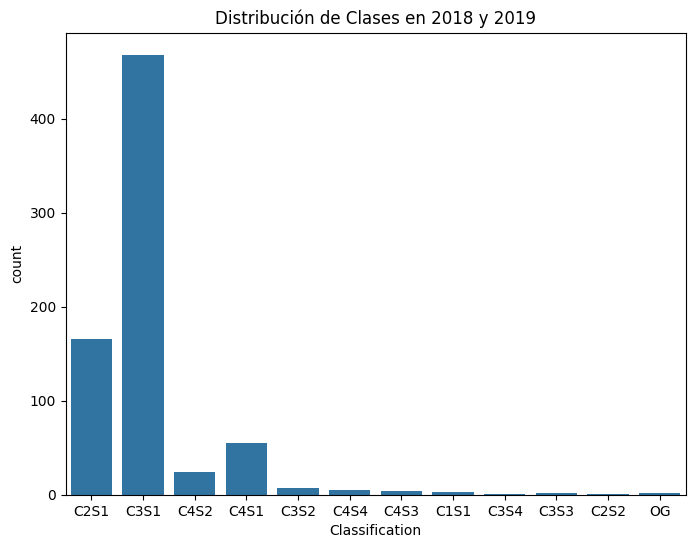

In [33]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Classification', data=data_agua)
plt.title('Distribución de Clases en 2018 y 2019')
plt.show()

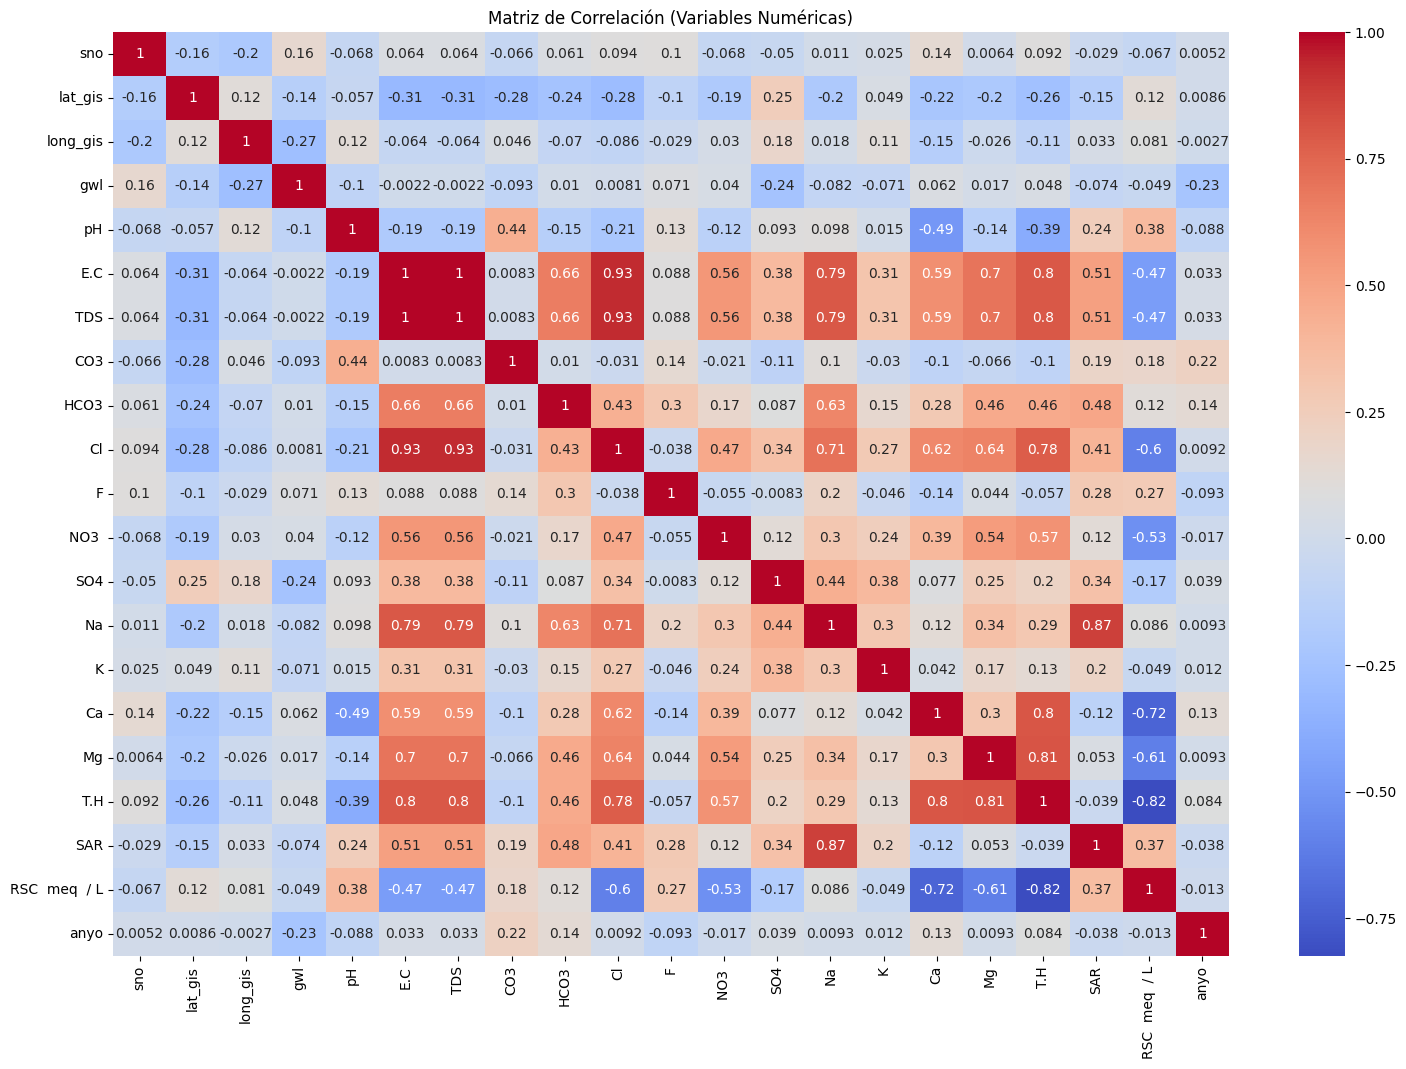

In [34]:
# Seleccionar las variables numéricas
numeric_features = data_agua.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación entre las variables numéricas
correlation_matrix = numeric_features.corr()

# Crear una figura para la visualización
plt.figure(figsize=(18, 12))

# Visualizar la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación (Variables Numéricas)')
plt.show()

In [35]:
# Dividir los datos en conjuntos de entrenamiento (2018 y 2019) y prueba (2020)
X_train = data_agua.drop(columns=['Classification', 'Classification.1'])
y_train = data_agua['Classification']
X_test = data_2020.drop(columns=['Classification', 'Classification.1'])
y_test = data_2020['Classification']


## StandardScaler

In [36]:

# Seleccionar las características numéricas y categóricas
numeric_features = X_train.select_dtypes(include=['float64', 'int64'])
categorical_features = X_train.select_dtypes(include=['object'])

# Crear transformadores para las características numéricas y categóricas
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combinar los transformadores utilizando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features.columns),
        ('cat', categorical_transformer, categorical_features.columns)
    ])

# Crear un pipeline que incluye la transformación y el modelo
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())  # Puedes reemplazar esto con el modelo que estás utilizando
])

# Aplicar la transformación a los datos de entrenamiento
X_train_scaled = preprocessor.fit_transform(X_train)

# Aplicar la transformación a los datos de prueba
X_test_scaled = preprocessor.transform(X_test)

## DecisionTreeClassifier

In [37]:
# Árbol de decisión
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_scaled, y_train)
y_pred_dt = dt_classifier.predict(X_test_scaled)

In [38]:
# Evaluación del Árbol de Decisión
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Accuracy del Árbol de Decisión:", accuracy_dt)
print(classification_report(y_test, y_pred_dt))

Accuracy del Árbol de Decisión: 0.9347826086956522
              precision    recall  f1-score   support

        C2S1       1.00      1.00      1.00        82
        C3S1       0.99      0.99      0.99       228
        C3S2       0.50      0.40      0.44         5
        C3S3       0.67      0.50      0.57         4
        C3S4       0.00      0.00      0.00         0
        C4S1       0.86      0.75      0.80        32
        C4S2       0.44      0.67      0.53        12
        C4S3       0.00      0.00      0.00         1
        C4S4       0.50      0.50      0.50         2
         O.G       0.00      0.00      0.00         2
          OG       0.00      0.00      0.00         0

    accuracy                           0.93       368
   macro avg       0.45      0.44      0.44       368
weighted avg       0.94      0.93      0.94       368



c:\Users\conod\miniconda3\envs\water\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\conod\miniconda3\envs\water\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\conod\miniconda3\envs\water\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\conod\miniconda3\e

## RandomForestClassifier

In [39]:
# Bosque aleatorio
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_scaled, y_train)
y_pred_rf = rf_classifier.predict(X_test_scaled)

In [40]:
# Evaluación del Bosque Aleatorio
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy del Bosque Aleatorio:", accuracy_rf)
print(classification_report(y_test, y_pred_rf))

Accuracy del Bosque Aleatorio: 0.9293478260869565
              precision    recall  f1-score   support

        C2S1       1.00      1.00      1.00        82
        C3S1       0.97      1.00      0.98       228
        C3S2       1.00      0.20      0.33         5
        C3S3       1.00      0.25      0.40         4
        C4S1       0.69      0.84      0.76        32
        C4S2       0.17      0.08      0.11        12
        C4S3       0.00      0.00      0.00         1
        C4S4       0.67      1.00      0.80         2
         O.G       0.00      0.00      0.00         2

    accuracy                           0.93       368
   macro avg       0.61      0.49      0.49       368
weighted avg       0.92      0.93      0.91       368



c:\Users\conod\miniconda3\envs\water\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\conod\miniconda3\envs\water\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\conod\miniconda3\envs\water\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## SVM

In [41]:
# Máquina de vectores de soporte (SVM)
svm_classifier = SVC()
svm_classifier.fit(X_train_scaled, y_train)
y_pred_svm = svm_classifier.predict(X_test_scaled)

In [42]:
# Evaluación de la Máquina de Vectores de Soporte (SVM)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy de la Máquina de Vectores de Soporte (SVM):", accuracy_svm)
print(classification_report(y_test, y_pred_svm))

Accuracy de la Máquina de Vectores de Soporte (SVM): 0.8668478260869565
              precision    recall  f1-score   support

        C2S1       0.89      0.88      0.88        82
        C3S1       0.92      0.96      0.94       228
        C3S2       0.00      0.00      0.00         5
        C3S3       0.00      0.00      0.00         4
        C4S1       0.63      0.91      0.74        32
        C4S2       0.00      0.00      0.00        12
        C4S3       0.00      0.00      0.00         1
        C4S4       0.00      0.00      0.00         2
         O.G       0.00      0.00      0.00         2

    accuracy                           0.87       368
   macro avg       0.27      0.30      0.28       368
weighted avg       0.82      0.87      0.84       368



c:\Users\conod\miniconda3\envs\water\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\conod\miniconda3\envs\water\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\conod\miniconda3\envs\water\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Competicion de modelos para elegir el mejor 

In [43]:
# Crear los clasificadores
dt_classifier = DecisionTreeClassifier()
rf_classifier = RandomForestClassifier()
svm_classifier = SVC()

# Entrenar los modelos
dt_classifier.fit(X_train_scaled, y_train)
rf_classifier.fit(X_train_scaled, y_train)
svm_classifier.fit(X_train_scaled, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_dt = dt_classifier.predict(X_test_scaled)
y_pred_rf = rf_classifier.predict(X_test_scaled)
y_pred_svm = svm_classifier.predict(X_test_scaled)

# Evaluar los modelos y comparar su rendimiento
accuracy_dt = accuracy_score(y_test, y_pred_dt)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print("Accuracy del Árbol de Decisión:", accuracy_dt)
print("Accuracy del Bosque Aleatorio:", accuracy_rf)
print("Accuracy de la Máquina de Vectores de Soporte (SVM):", accuracy_svm)

# Imprimir informe de clasificación para cada modelo
print("\nInforme de clasificación del Árbol de Decisión:")
print(classification_report(y_test, y_pred_dt))

print("\nInforme de clasificación del Bosque Aleatorio:")
print(classification_report(y_test, y_pred_rf))

print("\nInforme de clasificación de la Máquina de Vectores de Soporte (SVM):")
print(classification_report(y_test, y_pred_svm))


Accuracy del Árbol de Decisión: 0.9293478260869565
Accuracy del Bosque Aleatorio: 0.9320652173913043
Accuracy de la Máquina de Vectores de Soporte (SVM): 0.8668478260869565

Informe de clasificación del Árbol de Decisión:
              precision    recall  f1-score   support

        C2S1       1.00      1.00      1.00        82
        C3S1       1.00      0.99      0.99       228
        C3S2       0.50      0.40      0.44         5
        C3S3       0.60      0.75      0.67         4
        C4S1       0.75      0.75      0.75        32
        C4S2       0.38      0.50      0.43        12
        C4S3       0.00      0.00      0.00         1
        C4S4       0.00      0.00      0.00         2
         O.G       0.00      0.00      0.00         2
          OG       0.00      0.00      0.00         0

    accuracy                           0.93       368
   macro avg       0.42      0.44      0.43       368
weighted avg       0.93      0.93      0.93       368


Informe de clasifi

c:\Users\conod\miniconda3\envs\water\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\conod\miniconda3\envs\water\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\conod\miniconda3\envs\water\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\conod\miniconda3\e

In [44]:
# Predecir con los modelos entrenados
y_pred_dt = dt_classifier.predict(X_test_scaled)
y_pred_rf = rf_classifier.predict(X_test_scaled)
y_pred_svm = svm_classifier.predict(X_test_scaled)

# Comparar las predicciones con el conjunto de prueba
accuracy_dt = accuracy_score(y_test, y_pred_dt)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print("Accuracy del Árbol de Decisión :", accuracy_dt)
print("Accuracy del Bosque Aleatorio :", accuracy_rf)
print("Accuracy de la Máquina de Vectores de Soporte (SVM) :", accuracy_svm)


Accuracy del Árbol de Decisión : 0.9293478260869565
Accuracy del Bosque Aleatorio : 0.9320652173913043
Accuracy de la Máquina de Vectores de Soporte (SVM) : 0.8668478260869565


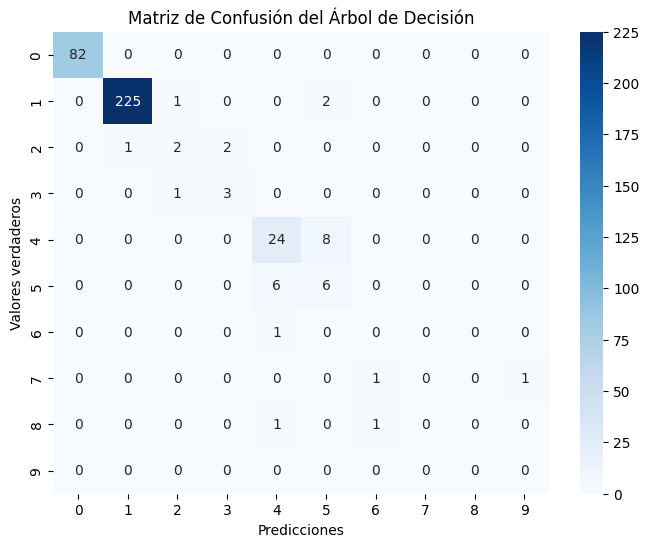

In [45]:
# Crear y visualizar la matriz de confusión para el Árbol de Decisión
confusion_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_dt, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicciones')
plt.ylabel('Valores verdaderos')
plt.title('Matriz de Confusión del Árbol de Decisión')
plt.show()

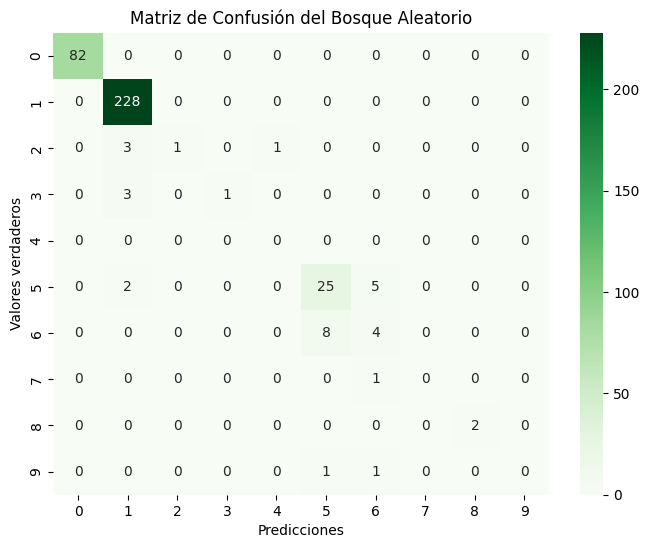

In [46]:
# Crear y visualizar la matriz de confusión para el Bosque Aleatorio
confusion_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_rf, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicciones')
plt.ylabel('Valores verdaderos')
plt.title('Matriz de Confusión del Bosque Aleatorio')
plt.show()

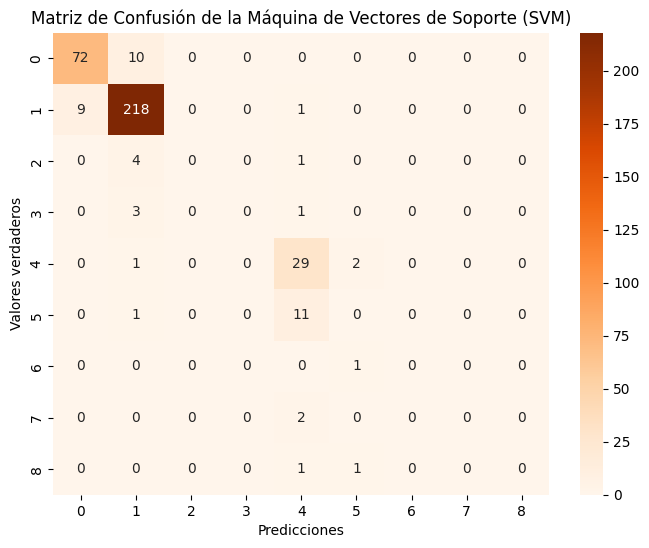

In [47]:
# Crear y visualizar la matriz de confusión para la Máquina de Vectores de Soporte (SVM)
confusion_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_svm, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicciones')
plt.ylabel('Valores verdaderos')
plt.title('Matriz de Confusión de la Máquina de Vectores de Soporte (SVM)')
plt.show()

## Funciones para poder llevar el proyecto a Streamlit 

In [48]:
# custom_functions.py

In [50]:
def entrenar_modelos(X_train, y_train):
    dt_classifier = DecisionTreeClassifier()
    rf_classifier = RandomForestClassifier()
    svm_classifier = SVC()

    dt_classifier.fit(X_train, y_train)
    rf_classifier.fit(X_train, y_train)
    svm_classifier.fit(X_train, y_train)

    return dt_classifier, rf_classifier, svm_classifier

def evaluar_modelos(dt_classifier, rf_classifier, svm_classifier, X_test, y_test):
    y_pred_dt = dt_classifier.predict(X_test)
    y_pred_rf = rf_classifier.predict(X_test)
    y_pred_svm = svm_classifier.predict(X_test)

    accuracy_dt = accuracy_score(y_test, y_pred_dt)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    accuracy_svm = accuracy_score(y_test, y_pred_svm)

    confusion_dt = confusion_matrix(y_test, y_pred_dt)
    confusion_rf = confusion_matrix(y_test, y_pred_rf)
    confusion_svm = confusion_matrix(y_test, y_pred_svm)

    return accuracy_dt, accuracy_rf, accuracy_svm, confusion_dt, confusion_rf, confusion_svm

In [51]:
accuracy_dt, accuracy_rf, accuracy_svm, confusion_dt, confusion_rf, confusion_svm

(0.9293478260869565,
 0.9320652173913043,
 0.8668478260869565,
 array([[ 82,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0, 225,   1,   0,   0,   2,   0,   0,   0,   0],
        [  0,   1,   2,   2,   0,   0,   0,   0,   0,   0],
        [  0,   0,   1,   3,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,  24,   8,   0,   0,   0,   0],
        [  0,   0,   0,   0,   6,   6,   0,   0,   0,   0],
        [  0,   0,   0,   0,   1,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   1,   0,   0,   1],
        [  0,   0,   0,   0,   1,   0,   1,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=int64),
 array([[ 82,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0, 228,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   3,   1,   0,   1,   0,   0,   0,   0,   0],
        [  0,   3,   0,   1,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   2,   0